In [1]:
import os 
import sys
#sys.path.append('/home/zbohan/projects/')
sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics import accuracy_score

from src.data.make_dataset import build_dataset
from src.models.word2vec.User2Subreddit import User2Subreddit

from sklearn.metrics import auc, roc_curve
from src.data.SubredditUserDataset import SubredditUserDataset
from src.features.interactions.political_comment import PoliticalComment
import bz2
import lzma
import json
#import zstandard as zstd
from json import JSONDecodeError
from collections import Counter
import math
import pandas as pd
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import numpy as np

In [2]:
def read_in_comments(in_file, count=-1):
    comments = []
    with open(in_file, 'r', encoding="utf-8") as f:
        for line in tqdm(f,total=count if count>0 else 137629803):
            line = line.strip()
            try:
                comment_id, parent_id, username, subreddit, created, politics, text = line.split('\t')
                political_comment = PoliticalComment(comment_id, parent_id, username, subreddit, created, politics,
                                                     text)
                comments.append(political_comment.to_dict())
                if count > 0 and len(comments) >= count:
                    print("Total number of political comments: {}".format(len(comments)))
                    return comments
            except Exception:
                pass

    print("Total number of political comments: {}".format(len(comments)))
    return comments

In [3]:
def read_in_bad_actors_from_tsv(in_files):
    bad_actors = defaultdict(list)

    for in_file in in_files:
        print("Reading in user politics from file: {}".format(in_file))
        with open(in_file, 'r',encoding="utf-8") as f:
            for line in f:
                user, politics, regex_match, subreddit, created, text = line.split('\t')
                entry = {'politics': politics, 'regex_match': regex_match, 'subreddit': subreddit,
                         'created': created,
                         'text': text}
                bad_actors[user].append(entry)

    return bad_actors

In [15]:
in_file = '/shared/0/projects/reddit-political-affiliation/data/interactions/all_comments_filtered.tsv'
comments = read_in_comments(in_file,count=10000000)
df_comments = pd.DataFrame(comments)
df_comments

20000130it [01:29, 222491.25it/s]                             


Total number of political comments: 10000000


,comment_id,parent_id,username,subreddit,created,politics,text
0,eypc9zv,eyp9duh,CueDramaticMusic,tumblr,1567296002,Democrat,I don’t know whether to read the last sentence...
1,eypca5l,eypby8b,ninethirtyone,news,1567296005,Democrat,You responded to my comment to make a point yo...
2,eypca5t,t3_cy2nlj,lostapwbm,SquaredCircle,1567296006,Democrat,After the fantastic energy of the crowds for T...
3,eypca8l,eypbz6d,OlliesFreeOxen,news,1567296007,Unknown,Run away when you lose. Typical. You have your...
4,eypcaac,eyp5fjl,Based_Putin,news,1567296008,Unknown,What does this even mean?
...,...,...,...,...,...,...,...
9999995,f7xwfog,f7x3604,StevenSmithen,pathofexile,1574078457,Democrat,"Been there, keep it up my dude!"
9999996,f7xwfr5,f7x9wxt,DONT_reply_with_THIS,AskThe_Donald,1574078459,Democrat,"&gt;Sure, but it would be an extremely unlikel..."
9999997,f7xwfu7,f7qk7wn,murphykills,Whatcouldgowrong,1574078462,Democrat,"yeah, nobody ever loses their balance while ex..."
9999998,f7xwfub,t3_dxtg35,wEiRdO86,KimPossibleRule34,1574078462,Democrat,Old Shadman art.


In [16]:
bad_dir='/shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/'
comments_dir=bad_dir+'comments/'
bad_actors = read_in_bad_actors_from_tsv(['/shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/bad_actors_30.tsv'])
print("# of bad actors: {}".format(len(bad_actors)))

Reading in user politics from file: /shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/bad_actors_30.tsv
# of bad actors: 2214


In [17]:
df_bad_actors=df_comments[df_comments['username'].isin(bad_actors.keys())]
df_partisan=df_comments[~df_comments['username'].isin(bad_actors.keys())]
df_partisan=df_partisan[df_partisan['politics']!='Unknown']
bad_actor_subreddit_counts=dict(df_bad_actors['subreddit'].value_counts())
partisian_subreddit_counts=dict(df_partisan['subreddit'].value_counts())


In [18]:
print(len(bad_actor_subreddit_counts),len(partisian_subreddit_counts))

8142 35248


In [19]:
def LoadCounts(word_counts, min_count=0):
    result = defaultdict(int)
    for word, count in word_counts.items():
        if count >= min_count:
              result[word] = count
    return result
  
def LoadStopwords(filename):
    stopwords = set()
    for line in open(filename):
        for word in line.split():
            if word:
                stopwords.add(word)
    return stopwords


def ComputeLogOdds(counts1, counts2, prior):
    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word] + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())


    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    return delta

In [20]:
def combine_count_log_odds(logodds,neg_counts,pos_counts):
    neg_counts['frequency'] = neg_counts['count'] / neg_counts['count'].sum()
    neg_logodds = logodds[logodds['log_odds'] < 0]
    neg_logodds = neg_logodds.merge(neg_counts,on='ngram')
    
    pos_counts['frequency'] = pos_counts['count'] / pos_counts['count'].sum()
    pos_logodds = logodds[logodds['log_odds'] > 0]
    pos_logodds = pos_logodds.merge(pos_counts,on='ngram')
    return pd.concat([neg_logodds,pos_logodds])#,pos_logodds,neg_logodds

In [21]:
def plot_log_odds(odds_freq,sig_val=1.96,min_freq=1e-5,max_odds=100,min_odds=-100):
    odds_freq = odds_freq[odds_freq['frequency'] >= min_freq]
    x_vals = list(odds_freq['frequency'])
    y_vals = list(odds_freq['log_odds'])
    y_vals = [max(v,min_odds) for v in y_vals] 
    y_vals = [min(v,max_odds) for v in y_vals]
    sizes = [min(12,2*abs(v)) for v in y_vals]
    #sizes=[10]*len(sizes)
    neg_color, pos_color, insig_color = ('green', 'purple', 'grey')
    colors = []
    annots = []
    pos_list={}
    neg_list={}
    
    for index, row in odds_freq.iterrows():
        if row['log_odds'] > sig_val:
            colors.append(pos_color)
            annots.append(row['ngram'])
            pos_list[row['ngram']]=row['log_odds']
        elif row['log_odds'] < -sig_val:
            colors.append(neg_color)
            annots.append(row['ngram'])
            neg_list[row['ngram']]=row['log_odds']
        else:
            colors.append(insig_color)
            annots.append(None)

    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0,s=1)
    for i, annot in enumerate(annots):
        if annot is not None:
            ax.annotate(annot, (x_vals[i], y_vals[i]), color=colors[i],size=sizes[i])
    ax.set_xscale('log')
    ax.set_xlabel('frequency')
    ax.set_ylabel('log odds')
    ax.set_yscale('symlog',linthreshy=15)
    return pos_list,neg_list

In [22]:
min_count =5
prior = defaultdict(lambda:0)

counts1 = LoadCounts(bad_actor_subreddit_counts, min_count)
counts2 = LoadCounts(partisian_subreddit_counts, min_count)
print(len(counts1),len(counts2))
#prior = LoadCounts(prior, min_count, stopwords)
delta = ComputeLogOdds(counts1, counts2, prior)

# count_file='/shared/0/projects/reddit-political-affiliation/data/word2vec/'+year_month+'_count.tsv'
# with open(count_file, 'w') as fp:
#     for word, log_odds in sorted(delta.items(), key=lambda x: x[1]):
#         fp.write("{}\t{:.3f}\n".format(word, log_odds))


2707 16771


In [23]:
pd_left_counts=pd.DataFrame(dict(counts1).items(),columns=['ngram','count'])
pd_right_counts=pd.DataFrame(dict(counts2).items(),columns=['ngram','count'])
logodds=pd.DataFrame(dict(delta).items(),columns=['ngram','log_odds'])

In [31]:
odd_freq=combine_count_log_odds(logodds,pd_left_counts,pd_right_counts)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


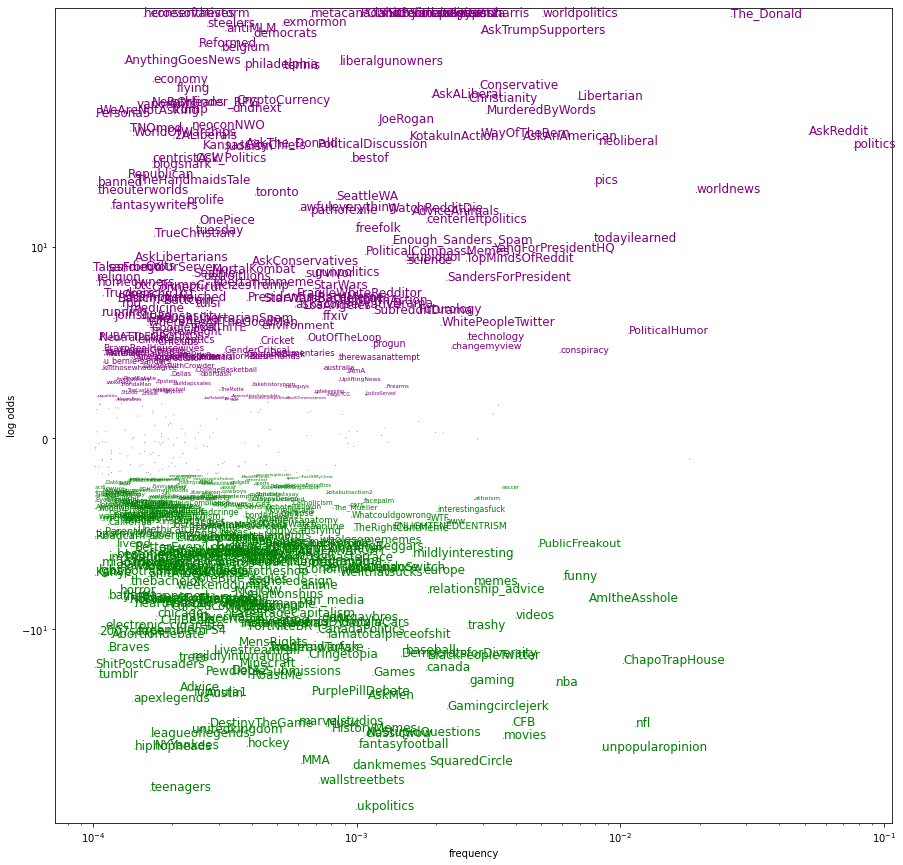

In [25]:
p,n=plot_log_odds(odd_freq,sig_val=1.96,min_freq=1e-4,max_odds=50,min_odds=-50)